# BigTable MTLM - summative Q-Matrix mining
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [77]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

# n_traits = 10
# active_traits = 10


In [78]:
generate_student_name()

'PHUTHY CORE '

In [79]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [80]:
active_traits = 100
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/active_traits)
pr_k_hardest = q_p_hardest**(1/active_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print("b", beta_min, beta_max)
print("th", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

null_task_pr = 1/(1+exp(-baseline))
print("null-task passrate", null_task_pr)
print("all-null passrate", null_task_pr**active_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**active_traits)
print("best Pr=", best_comp_pr**active_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
b 1 4.075196407410573
th 7.130072753253939 10.205269160664512
null-task passrate 0.7310585786300049
all-null passrate 2.4843785557240134e-14
worst cmp chance= 0.9549925860214361
best cmp chance= 0.9998995016917583
worst Pr= 0.010000000000000165
best Pr= 0.9900000000000009
limits 0.9978283039153395 0.9978283039153395
[[1 2 3]
 [7 8 9]]
(2, 3)


In [81]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [82]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        self.id = qix

#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
#         n_c =  numpy.random.choice(range(1,active_traits))
        n_c = nt
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_diff-min_diff)*len(choices))

        not_present= 0#min_diff
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.betas[c] = random.uniform(min_diff, max_diff)
            self.betas[c]= uniform(min_diff, max_diff) #(1,11)
    
class Student():
    def __init__(self, ix, min_a, max_a, nt=None, nnw=None, optimiser=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.thetas[c] = random.uniform(min_a, max_a)  
            self.thetas[c] = uniform(min_a, max_a) #(7,22)


In [83]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [84]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
        if b==0:
            p_pass_step=1.0
        else:
            if th==0:
#                 print("blocking component, ret 0")
                return 0
            else:
                z = (th-b)
                p_pass_step = 1.0 / (1.0 + exp(-z))
#                 print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [85]:
def create_qs(n_qs, beta_min, beta_max, nt, nnw):
#     random.seed(666)
#     numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
    return master_qs, qn_table

In [86]:
def create_students(n_students, theta_min, theta_max, nt, nnw):
#     random.seed(666)
#     numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
        comps = [c for c in psi.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
        mags.append(mag)
    
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    print("psi_table wgts", psi_table.get_weights())
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)

    if nt >1:
        itemz = array([ s.thetas for s in psi_list ])
    #     fig.set_size_inches(10, 10)
        ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
        for i, txt in enumerate(itemz):
            ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
        plt.show()
    
    return psi_list, psi_table
    

In [87]:
def generate_qs_model(qn_table, psi_table, qn_qmx, psi_qmx, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
#     qn_qmx.trainable = True
#     psi_qmx.trainable = True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

#     qn_qmx_row = qn_qmx(qn_sel)
#     psi_qmx_row = psi_qmx(psi_sel)

#     not_q = Lambda(lambda z: 1.0 / (1.0 + K.exp(10.0*z-5)), name="NOT_GATE")(qn_qmx_row)
#     scale = Lambda(lambda x1: 10.0*x1)
#     scale_sub = Lambda(lambda x2: 10.0*x2 - 5.0)

    
    ####
    # q0,s0 -> 1
    # q0,s1 -> 1
    # q1,s0 -> 0
    # q1,s1 -> cPr
    
#     p = scale_sub(psi_row)
#     not_q = scale(not_q)
#     qmx_selector = add([p, not_q])

    q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
    s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)
#     q_masque = qn_row
#     s_masque = psi_row

    q1_s1 = Lambda(lambda qs: qs[0] * qs[1])([q_masque, s_masque])
    q0 = Lambda(lambda q: 1-q)(q_masque)

    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)

#     Prs = multiply([Prs, q1_s1])
#     Prs = add([Prs, q0])
    
#     topped_up = Lambda(lambda ps_q:  K.clip(ps_q[0]+(1.0-ps_q[1]), 0,1))([Prs_holed, q_masque])

#     Prs = Lambda(lambda u: K.clip(u,0,1)) (add([Prs, qmx_selector]))
#     Prs = multiply([Prs, qmx_selector])

    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [88]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    n_pass = 0
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
#                 while (not passed) and att<user_patience:
                pp,passed = attempt_q(psi, q)
                if passed:
                    n_pass+=1
                tup = (psi.id, q.id, passed, passed)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)
#                 print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                att += 1
#                 if (not pass_to_remove) or (pass_to_remove and passed):
                qs.remove(qix)
#                 print("len qs is", len(qs))
    gc.collect()
    print(">>Passed {}/{}".format(n_pass, len(attempts)))
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [89]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        psi_wgts[s.id,:] = numpy.random.uniform(min_th,max_th, size=psi_wgts.shape[1])
        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        qn_wgts[q.id,:]= numpy.random.uniform(min_b,max_b, size=qn_wgts.shape[1])
        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [101]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, val, attempts_by_psi, attempts_by_q, s_table, q_table, s_qmx_table, q_qmx_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 10
    patience = init_patience

    print(attempts[0:100])

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
    
    vqices = array([int(tup[1]) for tup in val]).flatten() #reshape(-1,1)
    vpsices = array([int(tup[0]) for tup in val]).flatten() #reshape(-1,1)
    vpfs = array([tup[2] for tup in val]).flatten() #reshape(-1,1)

    qz = qices
    sz = psices
    pfz = pfs

    
    print(qz)
    print(sz)
    print(pfz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = False
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            loss, mse, acc = qs_model.evaluate(x=[vqices, vpsices], y=vpfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            sub_h.append((loss,mse,acc))


            print("i =",i)
     
            print(loss,mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse = acc #(th_rmse+b_rmse)/2.0
#             av_rmse = b_rmse
            av_rmse = loss
            print("av RMSE=",av_rmse)
            if av_rmse <= min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
#                 qs_model.save_weights("qs_best_weights_summative.hdf5")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break
                    
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h


In [91]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

Q:0, difficulty=19.61 across 5 components
Q:1, difficulty=17.83 across 5 components
Q:2, difficulty=22.03 across 5 components
Q:3, difficulty=17.86 across 5 components
Q:4, difficulty=18.47 across 5 components
Q:5, difficulty=17.56 across 5 components
Q:6, difficulty=15.40 across 5 components
Q:7, difficulty=14.55 across 5 components
Q:8, difficulty=20.86 across 5 components
Q:9, difficulty=21.57 across 5 components
Q:10, difficulty=21.92 across 5 components
Q:11, difficulty=18.09 across 5 components
Q:12, difficulty=17.68 across 5 components
Q:13, difficulty=16.63 across 5 components
Q:14, difficulty=16.95 across 5 components
Q:15, difficulty=20.73 across 5 components
Q:16, difficulty=23.48 across 5 components
Q:17, difficulty=13.42 across 5 components
Q:18, difficulty=12.03 across 5 components
Q:19, difficulty=12.50 across 5 components
Q:20, difficulty=18.93 across 5 components
Q:21, difficulty=20.73 across 5 components
Q:22, difficulty=21.83 across 5 components
Q:23, difficulty=19.8

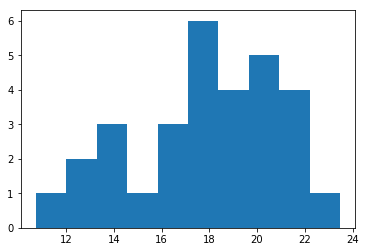

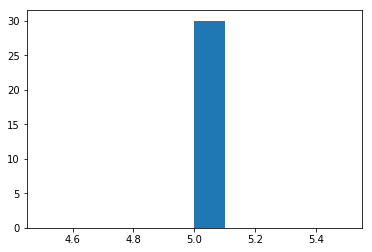

qid 0 [7.505640217125469, 10.302235356938759, 7.105076840792715, 6.909379471477099, 11.129908385822379]
qid 1 [9.409572914229159, 4.108278844084621, 10.332837859372493, 7.983063682985747, 6.4694430589406995]
qid 2 [3.1508864017885396, 11.707103397053698, 11.899360449949688, 11.026431189548765, 8.661989638240108]
qid 3 [4.527938086103493, 3.894422312986012, 9.13397693167272, 8.4946137658973, 11.29493070936122]
qid 4 [9.322627362349078, 11.64105525404124, 7.653424822677671, 3.77723087073112, 6.780590797369253]
qid 5 [11.111030773770693, 4.172096280427443, 8.582160699355153, 7.756605193684907, 5.800374552030213]
qid 6 [3.4128513361799095, 10.531944323127316, 3.4575715029446807, 9.634314643668624, 3.12559035884044]
qid 7 [5.304315994901627, 4.957633882295574, 9.84129992634239, 7.148749406713674, 3.3097489014102095]
qid 8 [10.357728193901046, 6.835888693433923, 9.761717707170202, 7.508817779134236, 11.37064080896559]
qid 9 [6.773663323295613, 11.347742675455143, 10.150682395991502, 7.787069

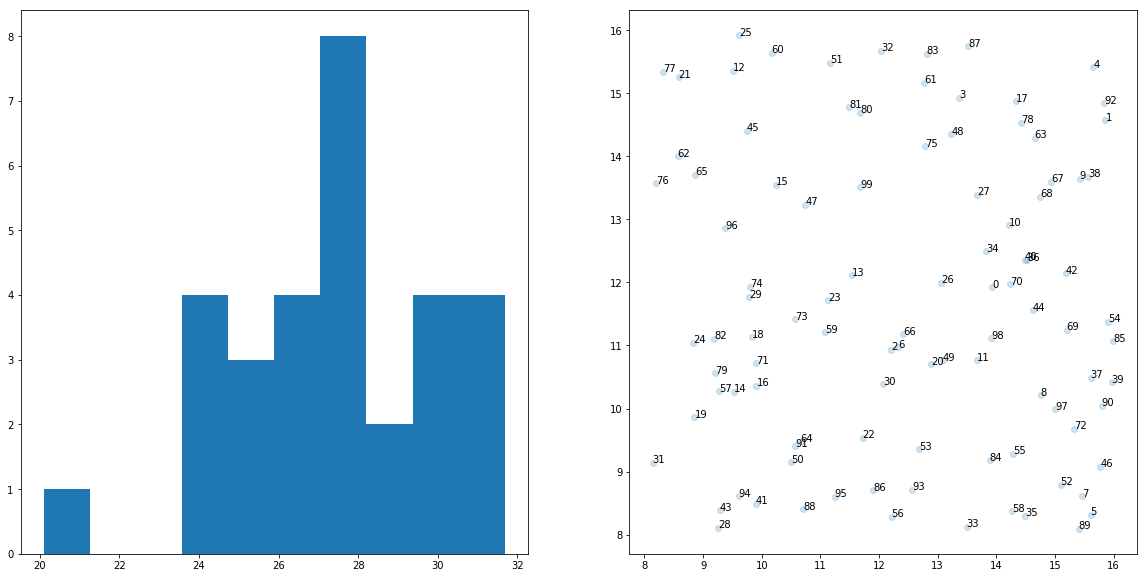

----0

>>Passed 1381/3000
----0

>>Passed 1381/3000
<__main__.BigTable object at 0x00000016D79F8630> <__main__.BigTable object at 0x00000016DBB4B630> Tensor("psi_select_36:0", shape=(?, 1), dtype=int32) Tensor("q_select_36:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (30, 1)
selector shape (?, 1)
flat selector shape (?,)
call kk (30, 1)
'rows' shape, (?, 1)
kk (100, 1)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 1)
'rows' shape, (?, 1)
dif (?, 1)
Pr (?, 1)
[ 15.27340698]
[ 14.61492157]
[ 9.38188362]
[ 14.16167164]
[ 14.90314388]
[ 11.15268135]
[ 11.34417534]
[ 14.43397236]
[ 11.90163708]
[ 10.96560955]
[ 15.99048901]
[ 13.47434616]
[ 10.82483006]
[ 12.91924572]
[ 8.17873096]
[ 10.07418919]
[ 15.5663414]
[ 13.37051201]
[ 10.14529324]
[ 12.01079655]
[ 10.64851284]
[ 11.72028446]
[ 8.90382862]
[ 14.58050346]
[ 14.16257]
[ 15.26814461]
[ 15.11648846]
[ 14.99404526]
[ 12.1479311]
[ 8.67490768]
[ 14.00863457]
[ 14.76418972]
[ 11.37301064]
[ 14.24628258]
[ 10.150719

1.95080904166 0.433678376635 0.485333333492
av RMSE= 1.95080904166
patience reset to 10
i = 460
1.94398946985 0.433034558972 0.486000000159
av RMSE= 1.94398946985
patience reset to 10
i = 470
1.93719370015 0.43238978529 0.486000000159
av RMSE= 1.93719370015
patience reset to 10
i = 480
1.93042612839 0.431745865544 0.486333333492
av RMSE= 1.93042612839
patience reset to 10
i = 490
1.92368107764 0.431101894577 0.487333333492
av RMSE= 1.92368107764
patience reset to 10
i = 500
1.91695397409 0.430456948638 0.488000000159
av RMSE= 1.91695397409
patience reset to 10
i = 510
1.91024924692 0.429811094721 0.487666666826
av RMSE= 1.91024924692
patience reset to 10
i = 520
1.90356511784 0.429164325237 0.488333333492
av RMSE= 1.90356511784
patience reset to 10
i = 530
1.8969047912 0.428516834378 0.489000000159
av RMSE= 1.8969047912
patience reset to 10
i = 540
1.89026169046 0.427868451317 0.489666666826
av RMSE= 1.89026169046
patience reset to 10
i = 550
1.88364254538 0.427219415983 0.490333333492

i = 1310
1.4401191624 0.376544153968 0.529000000159
av RMSE= 1.4401191624
patience reset to 10
i = 1320
1.43503284375 0.375869017164 0.529666666826
av RMSE= 1.43503284375
patience reset to 10
i = 1330
1.42996515894 0.375193653385 0.529666666826
av RMSE= 1.42996515894
patience reset to 10
i = 1340
1.4249149634 0.374518009543 0.529666666826
av RMSE= 1.4249149634
patience reset to 10
i = 1350
1.41988329124 0.373842105031 0.529666666826
av RMSE= 1.41988329124
patience reset to 10
i = 1360
1.4148690149 0.373165930589 0.530333333492
av RMSE= 1.4148690149
patience reset to 10
i = 1370
1.40987258132 0.372489505609 0.530666666826
av RMSE= 1.40987258132
patience reset to 10
i = 1380
1.40489424372 0.37181283919 0.531333333492
av RMSE= 1.40489424372
patience reset to 10
i = 1390
1.39993399096 0.371135970751 0.532000000159
av RMSE= 1.39993399096
patience reset to 10
i = 1400
1.3949916447 0.370458866954 0.533000000159
av RMSE= 1.3949916447
patience reset to 10
i = 1410
1.3900671382 0.369781544566 0.

i = 2160
1.07058425506 0.319440343698 0.565000000159
av RMSE= 1.07058425506
patience reset to 10
i = 2170
1.06694675255 0.318774592598 0.566666666826
av RMSE= 1.06694675255
patience reset to 10
i = 2180
1.06332518212 0.318109298428 0.566333333492
av RMSE= 1.06332518212
patience reset to 10
i = 2190
1.05971940931 0.317444444656 0.566666666826
av RMSE= 1.05971940931
patience reset to 10
i = 2200
1.05612950055 0.316780088226 0.567333333492
av RMSE= 1.05612950055
patience reset to 10
i = 2210
1.05255543089 0.316116227746 0.568000000159
av RMSE= 1.05255543089
patience reset to 10
i = 2220
1.04899725183 0.315452871362 0.567666666826
av RMSE= 1.04899725183
patience reset to 10
i = 2230
1.04545475531 0.314790031075 0.568333333492
av RMSE= 1.04545475531
patience reset to 10
i = 2240
1.04192802556 0.314127720237 0.568000000159
av RMSE= 1.04192802556
patience reset to 10
i = 2250
1.03841702604 0.313465958397 0.568333333492
av RMSE= 1.03841702604
patience reset to 10
i = 2260
1.03492172162 0.31280

i = 3000
0.817918537458 0.266454883615 0.616333333492
av RMSE= 0.817918537458
patience reset to 10
i = 3010
0.815524035454 0.265875711203 0.617000000159
av RMSE= 0.815524035454
patience reset to 10
i = 3020
0.81314222002 0.265297702193 0.617666666826
av RMSE= 0.81314222002
patience reset to 10
i = 3030
0.810772979418 0.264720841924 0.618333333492
av RMSE= 0.810772979418
patience reset to 10
i = 3040
0.808416382631 0.264145159284 0.618000000159
av RMSE= 0.808416382631
patience reset to 10
i = 3050
0.806072408358 0.263570649028 0.618333333492
av RMSE= 0.806072408358
patience reset to 10
i = 3060
0.803740976016 0.262997327209 0.620000000159
av RMSE= 0.803740976016
patience reset to 10
i = 3070
0.801422076543 0.262425193508 0.621000000159
av RMSE= 0.801422076543
patience reset to 10
i = 3080
0.799115668456 0.261854264537 0.621333333492
av RMSE= 0.799115668456
patience reset to 10
i = 3090
0.796821697394 0.261284539262 0.622333333492
av RMSE= 0.796821697394
patience reset to 10
i = 3100
0.7

i = 3840
0.657910100857 0.222564935287 0.666333333174
av RMSE= 0.657910100857
patience reset to 10
i = 3850
0.656470065037 0.222109552026 0.667333333174
av RMSE= 0.656470065037
patience reset to 10
i = 3860
0.655040117343 0.221655982216 0.669333333174
av RMSE= 0.655040117343
patience reset to 10
i = 3870
0.653620161057 0.221204214493 0.670333333174
av RMSE= 0.653620161057
patience reset to 10
i = 3880
0.65221021239 0.220754273733 0.670999999841
av RMSE= 0.65221021239
patience reset to 10
i = 3890
0.65081025513 0.220306180596 0.670666666508
av RMSE= 0.65081025513
patience reset to 10
i = 3900
0.649420266469 0.219859921455 0.670666666508
av RMSE= 0.649420266469
patience reset to 10
i = 3910
0.648040143569 0.219415506124 0.670999999841
av RMSE= 0.648040143569
patience reset to 10
i = 3920
0.646669919888 0.218972959717 0.670999999841
av RMSE= 0.646669919888
patience reset to 10
i = 3930
0.64530947868 0.218532261729 0.671666666508
av RMSE= 0.64530947868
patience reset to 10
i = 3940
0.64395

i = 4680
0.568577504396 0.191266913851 0.706333333174
av RMSE= 0.568577504396
patience reset to 10
i = 4690
0.567855976343 0.190985285083 0.706999999841
av RMSE= 0.567855976343
patience reset to 10
i = 4700
0.567141371727 0.190705854217 0.706999999841
av RMSE= 0.567141371727
patience reset to 10
i = 4710
0.56643363452 0.190428620736 0.707666666508
av RMSE= 0.56643363452
patience reset to 10
i = 4720
0.565732720137 0.190153578639 0.707999999841
av RMSE= 0.565732720137
patience reset to 10
i = 4730
0.565038609266 0.18988073043 0.707333333174
av RMSE= 0.565038609266
patience reset to 10
i = 4740
0.564351254543 0.189610074321 0.707333333174
av RMSE= 0.564351254543
patience reset to 10
i = 4750
0.563670606216 0.18934160618 0.706999999841
av RMSE= 0.563670606216
patience reset to 10
i = 4760
0.562996623278 0.189075326761 0.706666666508
av RMSE= 0.562996623278
patience reset to 10
i = 4770
0.562329251051 0.188811219414 0.706999999841
av RMSE= 0.562329251051
patience reset to 10
i = 4780
0.561

i = 5520
0.528050337712 0.174710946957 0.740666666508
av RMSE= 0.528050337712
patience reset to 10
i = 5530
0.527763772567 0.174589503368 0.740999999841
av RMSE= 0.527763772567
patience reset to 10
i = 5540
0.527480684996 0.174469511708 0.741333333174
av RMSE= 0.527480684996
patience reset to 10
i = 5550
0.527201111555 0.174350968242 0.741666666508
av RMSE= 0.527201111555
patience reset to 10
i = 5560
0.526924972296 0.174233852824 0.741666666508
av RMSE= 0.526924972296
patience reset to 10
i = 5570
0.526652195056 0.174118145029 0.741666666508
av RMSE= 0.526652195056
patience reset to 10
i = 5580
0.526382792552 0.17400383389 0.741333333174
av RMSE= 0.526382792552
patience reset to 10
i = 5590
0.526116754611 0.173890917897 0.740999999841
av RMSE= 0.526116754611
patience reset to 10
i = 5600
0.525853993813 0.173779372295 0.740999999841
av RMSE= 0.525853993813
patience reset to 10
i = 5610
0.525594524145 0.173669190248 0.741333333174
av RMSE= 0.525594524145
patience reset to 10
i = 5620
0.

i = 6370
0.513392552853 0.168423627853 0.750666666508
av RMSE= 0.513392552853
patience reset to 10
i = 6380
0.513304302295 0.168384836793 0.750666666508
av RMSE= 0.513304302295
patience reset to 10
i = 6390
0.513217413823 0.168346601168 0.750666666508
av RMSE= 0.513217413823
patience reset to 10
i = 6400
0.513131881396 0.168308920185 0.750666666508
av RMSE= 0.513131881396
patience reset to 10
i = 6410
0.513047663927 0.168271783948 0.750999999841
av RMSE= 0.513047663927
patience reset to 10
i = 6420
0.512964763959 0.168235177398 0.750333333174
av RMSE= 0.512964763959
patience reset to 10
i = 6430
0.512883184195 0.168199109753 0.750666666508
av RMSE= 0.512883184195
patience reset to 10
i = 6440
0.512802831014 0.168163555066 0.750666666508
av RMSE= 0.512802831014
patience reset to 10
i = 6450
0.512723768473 0.168128519018 0.750999999841
av RMSE= 0.512723768473
patience reset to 10
i = 6460
0.512645928621 0.168093985836 0.750999999841
av RMSE= 0.512645928621
patience reset to 10
i = 6470
0

i = 7210
0.509497156779 0.166575207114 0.756333333333
av RMSE= 0.509497156779
patience reset to 10
i = 7220
0.509481560946 0.166565229535 0.756666666667
av RMSE= 0.509481560946
patience reset to 10
i = 7230
0.509466465155 0.166555441936 0.756666666667
av RMSE= 0.509466465155
patience reset to 10
i = 7240
0.509451856852 0.166545833945 0.756666666667
av RMSE= 0.509451856852
patience reset to 10
i = 7250
0.509437708855 0.166536408583 0.756666666667
av RMSE= 0.509437708855
patience reset to 10
i = 7260
0.509424064795 0.166527166327 0.756666666667
av RMSE= 0.509424064795
patience reset to 10
i = 7270
0.509410880248 0.166518106182 0.756666666667
av RMSE= 0.509410880248
patience reset to 10
i = 7280
0.50939819932 0.1665092237 0.756666666667
av RMSE= 0.50939819932
patience reset to 10
i = 7290
0.509385916869 0.166500503321 0.756333333333
av RMSE= 0.509385916869
patience reset to 10
i = 7300
0.509374122063 0.166491958618 0.756
av RMSE= 0.509374122063
patience reset to 10
i = 7310
0.509362787485

i = 8070
0.508897351901 0.166185280403 0.754666666667
av RMSE= 0.508897351901
patience reset to 10
i = 8080
0.508897025585 0.166184327761 0.754666666667
av RMSE= 0.508897025585
patience reset to 10
i = 8090
0.508896830956 0.166183429241 0.754666666667
av RMSE= 0.508896830956
patience reset to 10
i = 8100
0.508896783034 0.166182588339 0.754666666667
av RMSE= 0.508896783034
patience reset to 10
i = 8110
0.508896882613 0.166181800147 0.754666666667
av RMSE= 0.508896882613
i = 8120
0.508897099257 0.16618106397 0.754666666667
av RMSE= 0.508897099257
i = 8130
0.508897443295 0.166180372556 0.754666666667
av RMSE= 0.508897443295
i = 8140
0.508897890488 0.166179727376 0.754666666667
av RMSE= 0.508897890488
i = 8150
0.50889852198 0.166179145475 0.754666666667
av RMSE= 0.50889852198
i = 8160
0.508899285793 0.166178616981 0.754666666667
av RMSE= 0.508899285793
i = 8170
0.508900186459 0.166178142726 0.754333333333
av RMSE= 0.508900186459
i = 8180
0.508901164214 0.166177697122 0.754333333333
av RMSE

i = 9120
0.509237766027 0.166213340541 0.754333333492
av RMSE= 0.509237766027
i = 9130
0.509241669814 0.166214059293 0.754333333492
av RMSE= 0.509241669814
i = 9140
0.509245567481 0.166214783291 0.754333333492
av RMSE= 0.509245567481
i = 9150
0.509249446392 0.166215509077 0.754333333492
av RMSE= 0.509249446392
i = 9160
0.509253319502 0.166216233949 0.754333333492
av RMSE= 0.509253319502
i = 9170
0.509257188559 0.166216960907 0.754333333492
av RMSE= 0.509257188559
i = 9180
0.509261046807 0.166217686097 0.754333333492
av RMSE= 0.509261046807
i = 9190
0.509264918566 0.166218428274 0.754333333492
av RMSE= 0.509264918566
i = 9200
0.509268738111 0.166219149729 0.754333333492
av RMSE= 0.509268738111
i = 9210
0.509272507826 0.166219867547 0.754333333492
av RMSE= 0.509272507826
i = 9220
0.509276250601 0.166220581293 0.754333333492
av RMSE= 0.509276250601
i = 9230
0.509279950539 0.166221285363 0.754333333492
av RMSE= 0.509279950539
i = 9240
0.509283662399 0.166221997201 0.754000000159
av RMSE= 0

[  6.92756367  10.41070938  10.94878578]
[ 8.62821579  9.87267876  4.99590778]
[  9.78606415   4.53688574  10.8589468 ]
[ 10.08160973   5.46385527   8.90580273]
[ 8.73683167  8.34260941  3.90399766]
[ 11.99314404   9.41212177   7.30515146]
[ 5.40255547  6.04574537  9.78163624]
[ 4.78933287  9.97407055  3.14430785]
[ 4.40848207  9.29937935  8.23594093]
[ 11.51827812  10.99833107   8.21325684]
[ 4.66510916  7.22819614  9.00697994]
[ 8.16936684  6.47395325  6.48749161]
[  8.8581953   11.5749836    3.06699181]
[ 10.48449516   3.2081089   10.01791477]
[  5.25697231  10.26899052  11.97211552]
[ 11.36565781   3.68352032   8.63364124]
[ 3.63671255  4.93685913  5.89390755]
[  8.49288845   4.75574207  10.11652946]
[ 9.85623741  3.75365281  7.85388708]
[ 6.33552599  9.40791798  3.2172699 ]
[ 6.53753948  4.79046392  8.78047276]
[ 6.07572508  3.93871999  6.1447444 ]
[  3.89471197  10.73718643   8.98623848]
[ 8.16683292  7.29960299  7.27172375]
[ 11.99697113   8.10242939   4.27197027]
[ 3.61763978  

i = 590
0.839295948903 0.278260259946 0.587666666508
av RMSE= 0.839295948903
patience reset to 10
i = 600
0.835731529951 0.277304421306 0.588333333174
av RMSE= 0.835731529951
patience reset to 10
i = 610
0.832220211109 0.27635912319 0.589333333174
av RMSE= 0.832220211109
patience reset to 10
i = 620
0.828760540962 0.275424127102 0.591333333174
av RMSE= 0.828760540962
patience reset to 10
i = 630
0.825351086934 0.274499159296 0.591666666508
av RMSE= 0.825351086934
patience reset to 10
i = 640
0.821990807136 0.27358414034 0.591333333174
av RMSE= 0.821990807136
patience reset to 10
i = 650
0.818690614303 0.272683580637 0.591999999841
av RMSE= 0.818690614303
patience reset to 10
i = 660
0.815436510086 0.271792307536 0.591999999841
av RMSE= 0.815436510086
patience reset to 10
i = 670
0.812225750605 0.270910949707 0.591999999841
av RMSE= 0.812225750605
patience reset to 10
i = 680
0.809058773359 0.270038519859 0.593333333174
av RMSE= 0.809058773359
patience reset to 10
i = 690
0.805934686581

i = 1430
0.65170138073 0.22219143645 0.659666666508
av RMSE= 0.65170138073
patience reset to 10
i = 1440
0.65032201155 0.221724391301 0.660666666508
av RMSE= 0.65032201155
patience reset to 10
i = 1450
0.648955787738 0.221260721008 0.660999999841
av RMSE= 0.648955787738
patience reset to 10
i = 1460
0.647602552811 0.220800392946 0.662333333174
av RMSE= 0.647602552811
patience reset to 10
i = 1470
0.646262205998 0.220343390584 0.662666666508
av RMSE= 0.646262205998
patience reset to 10
i = 1480
0.644934610605 0.219889680823 0.663333333174
av RMSE= 0.644934610605
patience reset to 10
i = 1490
0.643619594336 0.219439226985 0.663999999841
av RMSE= 0.643619594336
patience reset to 10
i = 1500
0.642316987594 0.21899200364 0.663999999841
av RMSE= 0.642316987594
patience reset to 10
i = 1510
0.641026748975 0.218547984083 0.664333333174
av RMSE= 0.641026748975
patience reset to 10
i = 1520
0.639748627106 0.218107136369 0.665333333174
av RMSE= 0.639748627106
patience reset to 10
i = 1530
0.63848

i = 2260
0.571788992008 0.192852160931 0.710999999841
av RMSE= 0.571788992008
patience reset to 10
i = 2270
0.571149990638 0.19259462446 0.711999999841
av RMSE= 0.571149990638
patience reset to 10
i = 2280
0.570516748349 0.192338976065 0.711666666508
av RMSE= 0.570516748349
patience reset to 10
i = 2290
0.569889204264 0.192085190356 0.711666666508
av RMSE= 0.569889204264
patience reset to 10
i = 2300
0.569267221689 0.191833244383 0.711666666508
av RMSE= 0.569267221689
patience reset to 10
i = 2310
0.568650765181 0.191583083212 0.712333333174
av RMSE= 0.568650765181
patience reset to 10
i = 2320
0.568039815505 0.191334757566 0.711666666508
av RMSE= 0.568039815505
patience reset to 10
i = 2330
0.567434342702 0.191088254372 0.711999999841
av RMSE= 0.567434342702
patience reset to 10
i = 2340
0.5668342158 0.190843543927 0.710666666508
av RMSE= 0.5668342158
patience reset to 10
i = 2350
0.566239441951 0.190600610077 0.710666666508
av RMSE= 0.566239441951
patience reset to 10
i = 2360
0.5656

i = 3100
0.533237723033 0.176577528298 0.734666666508
av RMSE= 0.533237723033
patience reset to 10
i = 3110
0.532913049777 0.176436028103 0.734999999841
av RMSE= 0.532913049777
patience reset to 10
i = 3120
0.532590566556 0.176295460383 0.735666666508
av RMSE= 0.532590566556
patience reset to 10
i = 3130
0.532270321846 0.17615583243 0.735999999841
av RMSE= 0.532270321846
patience reset to 10
i = 3140
0.531952258666 0.176017131348 0.736666666508
av RMSE= 0.531952258666
patience reset to 10
i = 3150
0.531636359612 0.175879349709 0.736333333174
av RMSE= 0.531636359612
patience reset to 10
i = 3160
0.531322622617 0.175742480775 0.735999999841
av RMSE= 0.531322622617
patience reset to 10
i = 3170
0.531011028846 0.175606517812 0.735333333492
av RMSE= 0.531011028846
patience reset to 10
i = 3180
0.530701584498 0.175471470535 0.736333333492
av RMSE= 0.530701584498
patience reset to 10
i = 3190
0.530394234737 0.175337299645 0.737000000159
av RMSE= 0.530394234737
patience reset to 10
i = 3200
0.

i = 3950
0.512995265404 0.167632776956 0.750333333333
av RMSE= 0.512995265404
patience reset to 10
i = 3960
0.512840387026 0.167559765637 0.750666666667
av RMSE= 0.512840387026
patience reset to 10
i = 3970
0.51268734177 0.167487412274 0.751
av RMSE= 0.51268734177
patience reset to 10
i = 3980
0.512535927852 0.16741569529 0.751
av RMSE= 0.512535927852
patience reset to 10
i = 3990
0.512386182388 0.167344603042 0.751
av RMSE= 0.512386182388
patience reset to 10
i = 4000
0.512238279422 0.16727417467 0.751666666667
av RMSE= 0.512238279422
patience reset to 10
i = 4010
0.512092134555 0.16720438683 0.752
av RMSE= 0.512092134555
patience reset to 10
i = 4020
0.511947816928 0.167135251045 0.751666666667
av RMSE= 0.511947816928
patience reset to 10
i = 4030
0.511805274884 0.16706675903 0.752
av RMSE= 0.511805274884
patience reset to 10
i = 4040
0.511664534648 0.166998913189 0.752333333333
av RMSE= 0.511664534648
patience reset to 10
i = 4050
0.511525530577 0.166931711058 0.752333333333
av RMSE

i = 4820
0.504485667864 0.163303612828 0.763666666667
av RMSE= 0.504485667864
patience reset to 10
i = 4830
0.504426327229 0.163272007823 0.763666666667
av RMSE= 0.504426327229
patience reset to 10
i = 4840
0.504367733399 0.163240778804 0.763333333333
av RMSE= 0.504367733399
patience reset to 10
i = 4850
0.504309870958 0.163209925652 0.763666666667
av RMSE= 0.504309870958
patience reset to 10
i = 4860
0.504252222459 0.163178956866 0.763666666667
av RMSE= 0.504252222459
patience reset to 10
i = 4870
0.504195073764 0.163148304701 0.763666666667
av RMSE= 0.504195073764
patience reset to 10
i = 4880
0.504138791243 0.163118122458 0.763666666667
av RMSE= 0.504138791243
patience reset to 10
i = 4890
0.504083331029 0.163088390827 0.764
av RMSE= 0.504083331029
patience reset to 10
i = 4900
0.504028574705 0.163059067925 0.764333333333
av RMSE= 0.504028574705
patience reset to 10
i = 4910
0.503974487543 0.163030138095 0.764666666667
av RMSE= 0.503974487543
patience reset to 10
i = 4920
0.50392114

i = 5680
0.501231203397 0.161679743965 0.765000000159
av RMSE= 0.501231203397
patience reset to 10
i = 5690
0.501213824272 0.161669383526 0.765000000159
av RMSE= 0.501213824272
patience reset to 10
i = 5700
0.501197196404 0.161659198284 0.764666666826
av RMSE= 0.501197196404
patience reset to 10
i = 5710
0.501181309303 0.161649178465 0.764666666826
av RMSE= 0.501181309303
patience reset to 10
i = 5720
0.501166169087 0.161639324268 0.765000000159
av RMSE= 0.501166169087
patience reset to 10
i = 5730
0.501151715676 0.161629621585 0.765666666826
av RMSE= 0.501151715676
patience reset to 10
i = 5740
0.501137933652 0.161620062868 0.765333333492
av RMSE= 0.501137933652
patience reset to 10
i = 5750
0.501124810855 0.161610642513 0.765000000159
av RMSE= 0.501124810855
patience reset to 10
i = 5760
0.501112359206 0.161601363023 0.765333333492
av RMSE= 0.501112359206
patience reset to 10
i = 5770
0.501100520213 0.161592212637 0.765333333492
av RMSE= 0.501100520213
patience reset to 10
i = 5780
0

i = 6640
0.501256867647 0.160946061611 0.770999999841
av RMSE= 0.501256867647
i = 6650
0.501271323601 0.160939881086 0.771333333174
av RMSE= 0.501271323601
i = 6660
0.501286325375 0.16093378969 0.771333333174
av RMSE= 0.501286325375
i = 6670
0.501301856597 0.160927800377 0.772333333174
av RMSE= 0.501301856597
i = 6680
0.501317888975 0.160921893954 0.772333333174
av RMSE= 0.501317888975
i = 6690
0.501334424734 0.160916084091 0.772333333174
av RMSE= 0.501334424734
i = 6700
0.501351500273 0.160910365423 0.772666666508
av RMSE= 0.501351500273
i = 6710
0.501369030714 0.160904740294 0.772999999841
av RMSE= 0.501369030714
i = 6720
0.501387077888 0.160899212797 0.772999999841
av RMSE= 0.501387077888
i = 6730
0.501405603886 0.160893784364 0.772999999841
av RMSE= 0.501405603886
i = 6740
0.501424637477 0.160888453166 0.773333333174
av RMSE= 0.501424637477
i = 6750
0.501444134633 0.16088321805 0.773666666508
av RMSE= 0.501444134633
i = 6760
0.501464120785 0.160878085931 0.773666666508
av RMSE= 0.5

i = 7700
0.505354999383 0.161240561525 0.775333333174
av RMSE= 0.505354999383
i = 7710
0.505418014844 0.161253631632 0.775333333174
av RMSE= 0.505418014844
i = 7720
0.505481458823 0.161266847332 0.775333333174
av RMSE= 0.505481458823
i = 7730
0.505545411905 0.16128019464 0.775333333174
av RMSE= 0.505545411905
i = 7740
0.505609604677 0.161293670336 0.775666666508
av RMSE= 0.505609604677
i = 7750
0.505672972043 0.161307172775 0.775333333174
av RMSE= 0.505672972043
i = 7760
0.505736654123 0.161320792198 0.775333333174
av RMSE= 0.505736654123
i = 7770
0.505800680955 0.16133452026 0.774999999841
av RMSE= 0.505800680955
i = 7780
0.505865013917 0.161348361214 0.774999999841
av RMSE= 0.505865013917
i = 7790
0.505929655711 0.161362288634 0.775333333174
av RMSE= 0.505929655711
i = 7800
0.505994626363 0.161376306852 0.775333333174
av RMSE= 0.505994626363
i = 7810
0.506059869925 0.161390399814 0.774999999841
av RMSE= 0.506059869925
i = 7820
0.506125283877 0.161404556235 0.774999999841
av RMSE= 0.5

i = 8760
0.510329558055 0.162202377637 0.776666666508
av RMSE= 0.510329558055
i = 8770
0.510357031981 0.162205515544 0.776333333174
av RMSE= 0.510357031981
i = 8780
0.510381996314 0.162208119273 0.775999999841
av RMSE= 0.510381996314
i = 8790
0.510404198011 0.162210169633 0.775333333492
av RMSE= 0.510404198011
i = 8800
0.510425103188 0.162212086082 0.775333333492
av RMSE= 0.510425103188
i = 8810
0.510445855141 0.162213938554 0.775333333492
av RMSE= 0.510445855141
i = 8820
0.510466400623 0.162215722442 0.775000000159
av RMSE= 0.510466400623
i = 8830
0.51048682038 0.162217448552 0.775000000159
av RMSE= 0.51048682038
i = 8840
0.510507185459 0.162219145139 0.775000000159
av RMSE= 0.510507185459
i = 8850
0.510527424812 0.162220793088 0.774666666826
av RMSE= 0.510527424812
i = 8860
0.510547620455 0.162222411871 0.774666666826
av RMSE= 0.510547620455
i = 8870
0.510567792098 0.162224003434 0.774666666826
av RMSE= 0.510567792098
i = 8880
0.51058795023 0.162225580533 0.774666666826
av RMSE= 0.51

i = 9820
0.512541334152 0.162461704135 0.775000000159
av RMSE= 0.512541334152
i = 9830
0.512557284355 0.162463577747 0.775000000159
av RMSE= 0.512557284355
i = 9840
0.512573200544 0.162465432286 0.775000000159
av RMSE= 0.512573200544
i = 9850
0.512589045842 0.162467256745 0.775000000159
av RMSE= 0.512589045842
i = 9860
0.512604900837 0.162469084104 0.774666666826
av RMSE= 0.512604900837
i = 9870
0.512620769342 0.162470898191 0.774666666826
av RMSE= 0.512620769342
i = 9880
0.512636552652 0.162472700198 0.774666666826
av RMSE= 0.512636552652
i = 9890
0.51265238603 0.162474484841 0.774666666826
av RMSE= 0.51265238603
i = 9900
0.512668182691 0.162476273974 0.774666666826
av RMSE= 0.512668182691
i = 9910
0.512683948358 0.162478036364 0.774333333492
av RMSE= 0.512683948358
i = 9920
0.512699766318 0.162479793747 0.774333333492
av RMSE= 0.512699766318
i = 9930
0.512715555509 0.162481537938 0.774333333492
av RMSE= 0.512715555509
i = 9940
0.512731334845 0.162483262817 0.774333333492
av RMSE= 0.5

[  8.66270638  10.19478893  11.43499756   3.31256366   9.42456627]
[ 6.34798336  8.72028923  5.50893641  3.90397286  6.43366957]
[ 10.94022369   3.36131573   4.09019756   5.78593969  10.97185612]
[ 6.69106722  8.05430889  5.34142637  6.23309517  4.84894419]
[ 8.52074051  9.82825089  3.11083817  9.29244041  8.61598587]
[  6.89392042   6.97737026   5.05186701  10.72976112   6.64448833]
[  6.99457502   5.74125576   9.43161488  10.69049835   4.76472187]
[ 10.87771893   7.02246714   8.95975685   7.71375513  11.194911  ]
[ 10.13574886   5.63527966   9.67736721   4.76458597   8.6013422 ]
[  4.03924847   5.94567966   6.70696497   5.50246191  10.29212952]
[ 10.86614513  11.8884058   10.30254555   5.73647738   4.74649048]
[ 4.54567575  4.31050253  3.49578166  3.17497015  6.68601322]
[ 11.37079048   4.08833742   3.33426857   4.93972731   6.82126427]
[  7.14864254   4.73144913   8.93517303   8.128438    11.61752796]
[  6.52588463  11.34262276   4.32539892  10.45450306   3.30977297]
[  5.24343395  

i = 500
0.747693240643 0.25398497653 0.621333333333
av RMSE= 0.747693240643
patience reset to 10
i = 510
0.744249201934 0.252854187767 0.622
av RMSE= 0.744249201934
patience reset to 10
i = 520
0.740870228926 0.251741544008 0.624
av RMSE= 0.740870228926
patience reset to 10
i = 530
0.737554368814 0.250646586776 0.625666666667
av RMSE= 0.737554368814
patience reset to 10
i = 540
0.734299768289 0.249568872571 0.627333333333
av RMSE= 0.734299768289
patience reset to 10
i = 550
0.73110459582 0.248507965446 0.628333333333
av RMSE= 0.73110459582
patience reset to 10
i = 560
0.72796714131 0.247463461518 0.630333333333
av RMSE= 0.72796714131
patience reset to 10
i = 570
0.724886689345 0.246435113311 0.629333333333
av RMSE= 0.724886689345
patience reset to 10
i = 580
0.721861884117 0.245422543645 0.630333333333
av RMSE= 0.721861884117
patience reset to 10
i = 590
0.718890059471 0.244425196012 0.63
av RMSE= 0.718890059471
patience reset to 10
i = 600
0.71596980079 0.243442730069 0.63
av RMSE= 0.

i = 1360
0.585179530303 0.196664454619 0.704999999841
av RMSE= 0.585179530303
patience reset to 10
i = 1370
0.58422414875 0.196294191917 0.705666666508
av RMSE= 0.58422414875
patience reset to 10
i = 1380
0.583280884425 0.195927996159 0.706333333174
av RMSE= 0.583280884425
patience reset to 10
i = 1390
0.582349674384 0.19556589067 0.706333333174
av RMSE= 0.582349674384
patience reset to 10
i = 1400
0.581430116494 0.19520777444 0.706666666508
av RMSE= 0.581430116494
patience reset to 10
i = 1410
0.58052223587 0.194853616198 0.706666666508
av RMSE= 0.58052223587
patience reset to 10
i = 1420
0.579625914415 0.194503381451 0.705666666508
av RMSE= 0.579625914415
patience reset to 10
i = 1430
0.578741023699 0.194157047709 0.706333333174
av RMSE= 0.578741023699
patience reset to 10
i = 1440
0.577867443879 0.19381457595 0.705999999841
av RMSE= 0.577867443879
patience reset to 10
i = 1450
0.577004865805 0.193475878994 0.705999999841
av RMSE= 0.577004865805
patience reset to 10
i = 1460
0.576153

i = 2200
0.534654405355 0.176255177816 0.741333333174
av RMSE= 0.534654405355
patience reset to 10
i = 2210
0.534300810575 0.176109503229 0.741999999841
av RMSE= 0.534300810575
patience reset to 10
i = 2220
0.53395089968 0.175965383212 0.742666666508
av RMSE= 0.53395089968
patience reset to 10
i = 2230
0.533604575157 0.175822783987 0.743333333174
av RMSE= 0.533604575157
patience reset to 10
i = 2240
0.533261785507 0.175681686362 0.743333333174
av RMSE= 0.533261785507
patience reset to 10
i = 2250
0.532922540744 0.175542081952 0.743333333174
av RMSE= 0.532922540744
patience reset to 10
i = 2260
0.532586740176 0.175403931101 0.743333333174
av RMSE= 0.532586740176
patience reset to 10
i = 2270
0.532254381577 0.175267228087 0.742999999841
av RMSE= 0.532254381577
patience reset to 10
i = 2280
0.531925388972 0.175131933053 0.743333333174
av RMSE= 0.531925388972
patience reset to 10
i = 2290
0.531599752982 0.174998043299 0.743999999841
av RMSE= 0.531599752982
patience reset to 10
i = 2300
0.5

i = 3050
0.513542009274 0.167701848904 0.757666666667
av RMSE= 0.513542009274
patience reset to 10
i = 3060
0.513388058583 0.16763773044 0.757333333333
av RMSE= 0.513388058583
patience reset to 10
i = 3070
0.513236108939 0.167574341297 0.758
av RMSE= 0.513236108939
patience reset to 10
i = 3080
0.513085416873 0.167511465311 0.757333333333
av RMSE= 0.513085416873
patience reset to 10
i = 3090
0.512934436083 0.167448637247 0.757666666667
av RMSE= 0.512934436083
patience reset to 10
i = 3100
0.512785487811 0.167386550506 0.758
av RMSE= 0.512785487811
patience reset to 10
i = 3110
0.512638586998 0.167325203816 0.758333333333
av RMSE= 0.512638586998
patience reset to 10
i = 3120
0.512493677696 0.167264587045 0.759333333333
av RMSE= 0.512493677696
patience reset to 10
i = 3130
0.51235076189 0.167204691291 0.760333333333
av RMSE= 0.51235076189
patience reset to 10
i = 3140
0.512209829013 0.16714551119 0.760666666667
av RMSE= 0.512209829013
patience reset to 10
i = 3150
0.512071029902 0.167087

i = 3900
0.505736323992 0.164097716093 0.767666666826
av RMSE= 0.505736323992
patience reset to 10
i = 3910
0.505689197461 0.164069507122 0.767666666826
av RMSE= 0.505689197461
patience reset to 10
i = 3920
0.505642765443 0.164041485707 0.767666666826
av RMSE= 0.505642765443
patience reset to 10
i = 3930
0.505597048203 0.164013666511 0.767333333492
av RMSE= 0.505597048203
patience reset to 10
i = 3940
0.505551999331 0.163986032923 0.768000000159
av RMSE= 0.505551999331
patience reset to 10
i = 3950
0.505507626375 0.163958577673 0.767666666826
av RMSE= 0.505507626375
patience reset to 10
i = 3960
0.50546395429 0.163931312641 0.767333333492
av RMSE= 0.50546395429
patience reset to 10
i = 3970
0.505420939048 0.163904232462 0.767666666826
av RMSE= 0.505420939048
patience reset to 10
i = 3980
0.50537866656 0.163877325376 0.767666666826
av RMSE= 0.50537866656
patience reset to 10
i = 3990
0.50533702151 0.16385059158 0.767333333492
av RMSE= 0.50533702151
patience reset to 10
i = 4000
0.505296

i = 4750
0.503175120274 0.162015614033 0.770333333333
av RMSE= 0.503175120274
patience reset to 10
i = 4760
0.503160756191 0.161995171428 0.77
av RMSE= 0.503160756191
patience reset to 10
i = 4770
0.503146906773 0.161974332849 0.77
av RMSE= 0.503146906773
patience reset to 10
i = 4780
0.503133940458 0.161953754147 0.769666666667
av RMSE= 0.503133940458
patience reset to 10
i = 4790
0.503121885697 0.16193351082 0.769666666667
av RMSE= 0.503121885697
patience reset to 10
i = 4800
0.503110678752 0.161913587411 0.769666666667
av RMSE= 0.503110678752
patience reset to 10
i = 4810
0.503100330432 0.161893980225 0.770333333333
av RMSE= 0.503100330432
patience reset to 10
i = 4820
0.503090804021 0.161874687394 0.770666666667
av RMSE= 0.503090804021
patience reset to 10
i = 4830
0.503082166433 0.161855713606 0.770666666667
av RMSE= 0.503082166433
patience reset to 10
i = 4840
0.503074361722 0.161837045074 0.770666666667
av RMSE= 0.503074361722
patience reset to 10
i = 4850
0.503067362944 0.16181

i = 5720
0.50408246398 0.161089277665 0.773666666508
av RMSE= 0.50408246398
i = 5730
0.50411204807 0.16108927842 0.774333333174
av RMSE= 0.50411204807
i = 5740
0.504140338421 0.161089250684 0.774333333174
av RMSE= 0.504140338421
i = 5750
0.50416795524 0.161089008292 0.773999999841
av RMSE= 0.50416795524
i = 5760
0.504195899407 0.161088828643 0.773999999841
av RMSE= 0.504195899407
i = 5770
0.504224159002 0.161088706652 0.773666666508
av RMSE= 0.504224159002
i = 5780
0.504251946688 0.1610885758 0.773666666508
av RMSE= 0.504251946688
i = 5790
0.504279457331 0.161088422894 0.773999999841
av RMSE= 0.504279457331
i = 5800
0.504307211876 0.161088293274 0.773333333174
av RMSE= 0.504307211876
i = 5810
0.504335275571 0.161088185191 0.772999999841
av RMSE= 0.504335275571
i = 5820
0.504363551537 0.161088094234 0.772666666508
av RMSE= 0.504363551537
i = 5830
0.504392116308 0.161088021278 0.773333333174
av RMSE= 0.504392116308
i = 5840
0.504420677582 0.16108787183 0.772999999841
av RMSE= 0.504420677

i = 6780
0.506488088131 0.160851051331 0.775000000159
av RMSE= 0.506488088131
i = 6790
0.506525308132 0.160852687379 0.776000000159
av RMSE= 0.506525308132
i = 6800
0.506563281854 0.160854533434 0.776666666826
av RMSE= 0.506563281854
i = 6810
0.506602020423 0.160856571118 0.776333333492
av RMSE= 0.506602020423
i = 6820
0.506641442776 0.160858813802 0.776666666826
av RMSE= 0.506641442776
i = 6830
0.50667900149 0.160860639234 0.777000000159
av RMSE= 0.50667900149
i = 6840
0.506717148304 0.160862650156 0.777333333492
av RMSE= 0.506717148304
i = 6850
0.506754851818 0.160864838481 0.777333333492
av RMSE= 0.506754851818
i = 6860
0.506793327093 0.160867274861 0.777666666826
av RMSE= 0.506793327093
i = 6870
0.506832536697 0.16086993885 0.778000000159
av RMSE= 0.506832536697
i = 6880
0.506872815688 0.160872881651 0.778000000159
av RMSE= 0.506872815688
i = 6890
0.506913729827 0.160876036008 0.778000000159
av RMSE= 0.506913729827
i = 6900
0.506955464999 0.160879442294 0.778333333492
av RMSE= 0.50

i = 7840
0.514648415724 0.161999066273 0.777000000159
av RMSE= 0.514648415724
i = 7850
0.514726948261 0.162011187196 0.777000000159
av RMSE= 0.514726948261
i = 7860
0.514806025743 0.162023422937 0.776666666826
av RMSE= 0.514806025743
i = 7870
0.514885718743 0.162035769304 0.776000000159
av RMSE= 0.514885718743
i = 7880
0.514965979179 0.162048226575 0.775666666826
av RMSE= 0.514965979179
i = 7890
0.515046556473 0.162060800572 0.775666666826
av RMSE= 0.515046556473
i = 7900
0.515127612273 0.162073492746 0.775666666826
av RMSE= 0.515127612273
i = 7910
0.515209289153 0.162086310248 0.775666666826
av RMSE= 0.515209289153
i = 7920
0.515291570505 0.162099255284 0.775666666826
av RMSE= 0.515291570505
i = 7930
0.515374464909 0.162112328728 0.775666666826
av RMSE= 0.515374464909
i = 7940
0.515458052397 0.162125526826 0.776000000159
av RMSE= 0.515458052397
i = 7950
0.515542257468 0.162138853987 0.776000000159
av RMSE= 0.515542257468
i = 7960
0.515627129873 0.162152313789 0.776000000159
av RMSE= 0

i = 8910
0.524236612479 0.163773481071 0.773666666826
av RMSE= 0.524236612479
i = 8920
0.524334417105 0.16379414318 0.773666666826
av RMSE= 0.524334417105
i = 8930
0.524432339271 0.163814811687 0.773666666826
av RMSE= 0.524432339271
i = 8940
0.524530337969 0.16383548226 0.773666666826
av RMSE= 0.524530337969
i = 8950
0.524628427347 0.163856151283 0.774000000159
av RMSE= 0.524628427347
i = 8960
0.5247266469 0.163876814604 0.774000000159
av RMSE= 0.5247266469
i = 8970
0.524823677778 0.163897441626 0.773666666826
av RMSE= 0.524823677778
i = 8980
0.524920349598 0.163918032328 0.773333333492
av RMSE= 0.524920349598
i = 8990
0.525017016172 0.163938599308 0.773333333492
av RMSE= 0.525017016172
i = 9000
0.525113664786 0.163959130108 0.773333333492
av RMSE= 0.525113664786
i = 9010
0.525210290909 0.16397962753 0.773333333492
av RMSE= 0.525210290909
i = 9020
0.525306828419 0.164000071247 0.773000000159
av RMSE= 0.525306828419
i = 9030
0.525403362989 0.164020480076 0.773000000159
av RMSE= 0.525403

i = 9990
0.533352766514 0.165606514951 0.774333333492
av RMSE= 0.533352766514
<__main__.BigTable object at 0x00000016E5F41908> <__main__.BigTable object at 0x00000016E643CA20> Tensor("psi_select_39:0", shape=(?, 1), dtype=int32) Tensor("q_select_39:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (30, 7)
selector shape (?, 1)
flat selector shape (?,)
call kk (30, 7)
'rows' shape, (?, 7)
kk (100, 7)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 7)
'rows' shape, (?, 7)
dif (?, 7)
Pr (?, 1)
[ 10.64657784  15.65334606   9.92229366   8.4698143   15.56004047
  11.72878838   9.20089531]
[  8.12611961   8.93473053  12.21526432   9.06033707  14.93900585
  13.49141312   9.66936016]
[ 10.65556335  10.9944334   13.91851711   8.33220196  14.76394272
   9.97749424  11.26971817]
[ 11.97398376  11.85586643  14.56803989  11.04283714  12.52880764
  15.17177486   9.51937389]
[  8.51767635  10.62349033   8.88390541  13.79396343  14.79193211
   9.39177704  13.51300335]
[ 14.47474098  1

[ 7.27149105  6.73251677  5.98053741  4.56043482  8.75556374  4.01252365
  8.08391285]
[ 3.37108088  9.20511341  7.84553003  7.94475079  8.24119377  9.50631046
  4.90635014]
[  5.41533518   9.09536362   6.17549229   8.46363544   9.12218857
   3.28140998  10.89714336]
[  4.12922382   6.62380934   4.40190506  10.53827572   5.65498972
   7.08237982   6.13998842]
[  3.81706715   8.12552547   9.38263607   6.07414865  10.48468876
   4.76677418   6.46950388]
[ 10.5036335    9.76498413   6.194314     3.57559752   3.92030931
  11.47444248   6.40128088]
[  3.72763991  10.72654247   5.52830791   9.67238235   7.84193516
   9.7759676   11.79297161]
[  4.16268873   7.28930521   6.26223946  10.14281273   5.37393332
  10.56216812   8.33677864]
[  3.42145824  11.1781435    5.71895933  10.47036648   8.85783386
  11.96290588   8.60480213]
[ 10.21975613  11.04642868   8.09233475   5.28626108   3.92533541
   8.73437309   8.05986786]
[ 11.92352581   7.98997259   7.89181519   6.88451242   9.12926674
   3.751

i = 410
0.702922999859 0.24427831157 0.617666666826
av RMSE= 0.702922999859
patience reset to 10
i = 420
0.699351863702 0.242986707687 0.619000000159
av RMSE= 0.699351863702
patience reset to 10
i = 430
0.695879635016 0.241723724405 0.621333333492
av RMSE= 0.695879635016
patience reset to 10
i = 440
0.692499788125 0.240488199989 0.622333333492
av RMSE= 0.692499788125
patience reset to 10
i = 450
0.689213539282 0.239283280055 0.623666666826
av RMSE= 0.689213539282
patience reset to 10
i = 460
0.686021586577 0.238109038313 0.627333333492
av RMSE= 0.686021586577
patience reset to 10
i = 470
0.682912068367 0.236959167163 0.629000000159
av RMSE= 0.682912068367
patience reset to 10
i = 480
0.679882669926 0.235833380342 0.629333333492
av RMSE= 0.679882669926
patience reset to 10
i = 490
0.676930318038 0.23473098139 0.631666666826
av RMSE= 0.676930318038
patience reset to 10
i = 500
0.674051850478 0.233651167432 0.632666666826
av RMSE= 0.674051850478
patience reset to 10
i = 510
0.671244575659

i = 1270
0.562790052414 0.188745270848 0.725
av RMSE= 0.562790052414
patience reset to 10
i = 1280
0.562055629333 0.188433053772 0.724333333333
av RMSE= 0.562055629333
patience reset to 10
i = 1290
0.561330785433 0.188124703805 0.725333333333
av RMSE= 0.561330785433
patience reset to 10
i = 1300
0.560615327915 0.187820159833 0.725333333333
av RMSE= 0.560615327915
patience reset to 10
i = 1310
0.55990908742 0.187519357244 0.725666666667
av RMSE= 0.55990908742
patience reset to 10
i = 1320
0.559211967707 0.187222257455 0.726333333333
av RMSE= 0.559211967707
patience reset to 10
i = 1330
0.558523785512 0.186928797126 0.726333333333
av RMSE= 0.558523785512
patience reset to 10
i = 1340
0.557844381889 0.186638916175 0.726
av RMSE= 0.557844381889
patience reset to 10
i = 1350
0.557174607833 0.186353847623 0.727
av RMSE= 0.557174607833
patience reset to 10
i = 1360
0.556513481696 0.186072417061 0.728000000159
av RMSE= 0.556513481696
patience reset to 10
i = 1370
0.555860734701 0.185794374863 

i = 2130
0.524553750118 0.172159405231 0.757333333333
av RMSE= 0.524553750118
patience reset to 10
i = 2140
0.524332517624 0.172056823691 0.757666666667
av RMSE= 0.524332517624
patience reset to 10
i = 2150
0.524115104596 0.17195575885 0.757333333333
av RMSE= 0.524115104596
patience reset to 10
i = 2160
0.523901825031 0.171856192589 0.757666666826
av RMSE= 0.523901825031
patience reset to 10
i = 2170
0.523692709366 0.171758110881 0.758000000159
av RMSE= 0.523692709366
patience reset to 10
i = 2180
0.523487329245 0.171661505222 0.758000000159
av RMSE= 0.523487329245
patience reset to 10
i = 2190
0.523285569747 0.171566326817 0.758666666826
av RMSE= 0.523285569747
patience reset to 10
i = 2200
0.523087506851 0.171472602844 0.759000000159
av RMSE= 0.523087506851
patience reset to 10
i = 2210
0.52289287893 0.171380304416 0.759333333492
av RMSE= 0.52289287893
patience reset to 10
i = 2220
0.522701846123 0.171289432208 0.758000000159
av RMSE= 0.522701846123
patience reset to 10
i = 2230
0.52

i = 2970
0.51472956411 0.167227155566 0.76
av RMSE= 0.51472956411
patience reset to 10
i = 2980
0.514708271106 0.167205273906 0.76
av RMSE= 0.514708271106
patience reset to 10
i = 2990
0.514689133883 0.167184107304 0.76
av RMSE= 0.514689133883
patience reset to 10
i = 3000
0.514672233979 0.167163650711 0.759999999841
av RMSE= 0.514672233979
patience reset to 10
i = 3010
0.514657470942 0.167143895745 0.759999999841
av RMSE= 0.514657470942
patience reset to 10
i = 3020
0.514644861142 0.167124842922 0.760333333174
av RMSE= 0.514644861142
patience reset to 10
i = 3030
0.514634375652 0.167106480956 0.760333333174
av RMSE= 0.514634375652
patience reset to 10
i = 3040
0.514625983079 0.167088796735 0.760333333174
av RMSE= 0.514625983079
patience reset to 10
i = 3050
0.51461966459 0.167071782827 0.760666666508
av RMSE= 0.51461966459
patience reset to 10
i = 3060
0.514615451972 0.167055437326 0.760999999841
av RMSE= 0.514615451972
patience reset to 10
i = 3070
0.514613241037 0.167039739927 0.759

i = 4000
0.520407521804 0.167422833006 0.762999999841
av RMSE= 0.520407521804
i = 4010
0.520522003333 0.16744053026 0.763333333174
av RMSE= 0.520522003333
i = 4020
0.520637553215 0.1674584922 0.763333333174
av RMSE= 0.520637553215
i = 4030
0.520754202763 0.167476718386 0.762999999841
av RMSE= 0.520754202763
i = 4040
0.520871917963 0.167495203137 0.762999999841
av RMSE= 0.520871917963
i = 4050
0.520990359942 0.167513928692 0.763666666508
av RMSE= 0.520990359942
i = 4060
0.521109743595 0.167532897433 0.763666666508
av RMSE= 0.521109743595
i = 4070
0.521230225722 0.16755213666 0.763666666508
av RMSE= 0.521230225722
i = 4080
0.521351794799 0.167571620862 0.763666666508
av RMSE= 0.521351794799
i = 4090
0.52147446386 0.167591359297 0.763666666508
av RMSE= 0.52147446386
i = 4100
0.521597918908 0.16761125795 0.764333333174
av RMSE= 0.521597918908
i = 4110
0.52172059679 0.16763080736 0.764666666508
av RMSE= 0.52172059679
i = 4120
0.521844374736 0.167650637865 0.764666666508
av RMSE= 0.521844374

i = 5060
0.535908130169 0.169864633799 0.765666666826
av RMSE= 0.535908130169
i = 5070
0.5360503486 0.169887473861 0.765333333492
av RMSE= 0.5360503486
i = 5080
0.536192929268 0.169910359422 0.765666666826
av RMSE= 0.536192929268
i = 5090
0.536335828304 0.169933279157 0.766000000159
av RMSE= 0.536335828304
i = 5100
0.536479119778 0.169956251105 0.765666666826
av RMSE= 0.536479119778
i = 5110
0.536622706413 0.169979255319 0.765333333492
av RMSE= 0.536622706413
i = 5120
0.536766609828 0.17000229315 0.765000000159
av RMSE= 0.536766609828
i = 5130
0.536910826683 0.170025359511 0.765000000159
av RMSE= 0.536910826683
i = 5140
0.537055342992 0.170048449636 0.764666666826
av RMSE= 0.537055342992
i = 5150
0.537200171471 0.170071560701 0.765666666826
av RMSE= 0.537200171471
i = 5160
0.53734525458 0.170094683568 0.765666666826
av RMSE= 0.53734525458
i = 5170
0.537490616798 0.17011780707 0.765666666826
av RMSE= 0.537490616798
i = 5180
0.537636051655 0.170140906533 0.765666666826
av RMSE= 0.5376360

i = 6140
0.550435504119 0.171887841662 0.766666666826
av RMSE= 0.550435504119
i = 6150
0.550536278248 0.171900005698 0.766333333492
av RMSE= 0.550536278248
i = 6160
0.550636792978 0.171912161708 0.766333333492
av RMSE= 0.550636792978
i = 6170
0.55073708264 0.171924299876 0.766333333492
av RMSE= 0.55073708264
i = 6180
0.550837100029 0.171936430415 0.766333333492
av RMSE= 0.550837100029
i = 6190
0.550936769327 0.171948548913 0.766333333492
av RMSE= 0.550936769327
i = 6200
0.551036412239 0.171960802476 0.766333333492
av RMSE= 0.551036412239
i = 6210
0.551138700644 0.171974293669 0.766333333492
av RMSE= 0.551138700644
i = 6220
0.55123990202 0.171987371008 0.766333333492
av RMSE= 0.55123990202
i = 6230
0.551340764681 0.172000461062 0.766000000159
av RMSE= 0.551340764681
i = 6240
0.55144143788 0.172013590296 0.765666666826
av RMSE= 0.55144143788
i = 6250
0.551541634401 0.172026587963 0.765666666826
av RMSE= 0.551541634401
i = 6260
0.551641453902 0.172039504449 0.765333333492
av RMSE= 0.55164

i = 7200
0.560975335121 0.173327593962 0.763000000159
av RMSE= 0.560975335121
i = 7210
0.561081304709 0.173344128251 0.763000000159
av RMSE= 0.561081304709
i = 7220
0.561187112808 0.173360821486 0.762666666826
av RMSE= 0.561187112808
i = 7230
0.561292709668 0.173377616882 0.762666666826
av RMSE= 0.561292709668
i = 7240
0.561398491939 0.173394330462 0.763000000159
av RMSE= 0.561398491939
i = 7250
0.561504516522 0.17341098094 0.763000000159
av RMSE= 0.561504516522
i = 7260
0.561610757669 0.173427617629 0.763000000159
av RMSE= 0.561610757669
i = 7270
0.561717304389 0.173444288413 0.762666666826
av RMSE= 0.561717304389
i = 7280
0.561824024439 0.173460973024 0.762666666826
av RMSE= 0.561824024439
i = 7290
0.561931043863 0.173477697968 0.762666666826
av RMSE= 0.561931043863
i = 7300
0.562038405975 0.173494495233 0.762666666826
av RMSE= 0.562038405975
i = 7310
0.56214608264 0.173511352301 0.762666666826
av RMSE= 0.56214608264
i = 7320
0.562254103343 0.173528278391 0.762333333492
av RMSE= 0.56

i = 8260
0.571871867816 0.175083313107 0.762000000159
av RMSE= 0.571871867816
i = 8270
0.571979061286 0.175102136672 0.761666666826
av RMSE= 0.571979061286
i = 8280
0.572086357276 0.175120975812 0.761666666826
av RMSE= 0.572086357276
i = 8290
0.572193617423 0.175139826775 0.761666666826
av RMSE= 0.572193617423
i = 8300
0.572300726573 0.175158670743 0.761666666826
av RMSE= 0.572300726573
i = 8310
0.572407741388 0.175177494208 0.761666666826
av RMSE= 0.572407741388
i = 8320
0.572514829795 0.175196329693 0.761666666826
av RMSE= 0.572514829795
i = 8330
0.57262192901 0.175215149661 0.761666666826
av RMSE= 0.57262192901
i = 8340
0.57272907273 0.17523396043 0.761999999841
av RMSE= 0.57272907273
i = 8350
0.572836229006 0.175252759496 0.761999999841
av RMSE= 0.572836229006
i = 8360
0.57294339331 0.175271532257 0.761999999841
av RMSE= 0.57294339331
i = 8370
0.573047530492 0.175288986047 0.761666666508
av RMSE= 0.573047530492
i = 8380
0.573151363373 0.175306263109 0.761666666508
av RMSE= 0.573151

i = 9320
0.58143140014 0.176077075919 0.765333333492
av RMSE= 0.58143140014
i = 9330
0.58149498566 0.176075346112 0.765666666826
av RMSE= 0.58149498566
i = 9340
0.581558428208 0.176073639313 0.765666666826
av RMSE= 0.581558428208
i = 9350
0.581620693684 0.176071767131 0.766000000159
av RMSE= 0.581620693684
i = 9360
0.581676381429 0.176068750103 0.766000000159
av RMSE= 0.581676381429
i = 9370
0.581732093255 0.176065726837 0.765333333492
av RMSE= 0.581732093255
i = 9380
0.581787341277 0.176062739134 0.765333333492
av RMSE= 0.581787341277
i = 9390
0.581842665831 0.176059782664 0.765000000159
av RMSE= 0.581842665831
i = 9400
0.581898107211 0.176056839585 0.765333333492
av RMSE= 0.581898107211
i = 9410
0.581953114351 0.176053877354 0.765333333492
av RMSE= 0.581953114351
i = 9420
0.582007904053 0.176050980051 0.765666666826
av RMSE= 0.582007904053
i = 9430
0.582062749863 0.176048092127 0.765666666826
av RMSE= 0.582062749863
i = 9440
0.582117529313 0.176045188626 0.765333333492
av RMSE= 0.582

[  9.11121941   6.71392155   8.36378956  11.77014923   4.3002224
  10.7078743    9.19576073   8.57371998  11.27981949  11.90674019]
[  3.46587396   8.04593182  10.49899101   5.86915016  11.80283165
   4.58994293   5.4463625   10.67586327  10.98130226   7.2970767 ]
[  5.44691706   8.51994896  11.03862286   3.97652602  10.22869873
   3.35634947   3.48199558   4.62979603   5.39656496   5.47160864]
[  9.11484623  10.39473915   8.973629     8.41728401  11.8092308
   9.01618958   3.12229466   9.52927208  11.9038105    7.35866499]
[  3.60088658  11.73002625   9.47635555   6.21267748  10.90876198
   3.89685607   6.15260601   4.73741817   4.45344877   9.84611797]
[  6.35040522   4.08917141  11.3152914    7.06013918   9.87055492
   4.52452087   7.95829248   3.40291977   9.26248741   3.37526727]
[  6.24602652   6.04891491   5.77941608   3.90988374  11.47690296
  10.01187897   5.20536518  10.76066017   6.73409605   8.85792923]
[  3.41628194   3.49328876   4.24842215  11.34867382   3.72442222
   7.

i = 290
0.757602371852 0.261042857329 0.605333333174
av RMSE= 0.757602371852
patience reset to 10
i = 300
0.751556427161 0.259164900819 0.605999999841
av RMSE= 0.751556427161
patience reset to 10
i = 310
0.74573615392 0.257337277095 0.608333333174
av RMSE= 0.74573615392
patience reset to 10
i = 320
0.740128560543 0.255557890097 0.609666666508
av RMSE= 0.740128560543
patience reset to 10
i = 330
0.734721707821 0.253824796478 0.610999999841
av RMSE= 0.734721707821
patience reset to 10
i = 340
0.729504724979 0.252136198958 0.613333333174
av RMSE= 0.729504724979
patience reset to 10
i = 350
0.724467465242 0.2504903754 0.613666666508
av RMSE= 0.724467465242
patience reset to 10
i = 360
0.719600718657 0.248885758201 0.616333333174
av RMSE= 0.719600718657
patience reset to 10
i = 370
0.714895817598 0.247320897857 0.619333333333
av RMSE= 0.714895817598
patience reset to 10
i = 380
0.710344990253 0.245795647184 0.623333333333
av RMSE= 0.710344990253
patience reset to 10
i = 390
0.705940548579 0

i = 1160
0.561174873034 0.188302169522 0.719
av RMSE= 0.561174873034
patience reset to 10
i = 1170
0.560450347662 0.187984669328 0.718666666667
av RMSE= 0.560450347662
patience reset to 10
i = 1180
0.559739623388 0.187672803958 0.719666666667
av RMSE= 0.559739623388
patience reset to 10
i = 1190
0.559042354822 0.187366450032 0.720333333333
av RMSE= 0.559042354822
patience reset to 10
i = 1200
0.55835848101 0.187065608144 0.722
av RMSE= 0.55835848101
patience reset to 10
i = 1210
0.557687742869 0.186770183285 0.721333333333
av RMSE= 0.557687742869
patience reset to 10
i = 1220
0.55702373449 0.18647867767 0.722
av RMSE= 0.55702373449
patience reset to 10
i = 1230
0.55636817805 0.186191454848 0.722666666667
av RMSE= 0.55636817805
patience reset to 10
i = 1240
0.555725106478 0.185909381111 0.723666666667
av RMSE= 0.555725106478
patience reset to 10
i = 1250
0.555095829566 0.185633273244 0.723666666667
av RMSE= 0.555095829566
patience reset to 10
i = 1260
0.55448420612 0.185365435481 0.7253

i = 2000
0.530074926694 0.174261696657 0.744000000159
av RMSE= 0.530074926694
patience reset to 10
i = 2010
0.529932674646 0.174189134558 0.745333333492
av RMSE= 0.529932674646
patience reset to 10
i = 2020
0.529793974876 0.174117990454 0.745000000159
av RMSE= 0.529793974876
patience reset to 10
i = 2030
0.529658755064 0.174048244158 0.745000000159
av RMSE= 0.529658755064
patience reset to 10
i = 2040
0.529526480118 0.173980057041 0.745333333492
av RMSE= 0.529526480118
patience reset to 10
i = 2050
0.529397386551 0.173913106322 0.745666666826
av RMSE= 0.529397386551
patience reset to 10
i = 2060
0.529271365404 0.173847326318 0.745333333492
av RMSE= 0.529271365404
patience reset to 10
i = 2070
0.52914813749 0.173782607992 0.745000000159
av RMSE= 0.52914813749
patience reset to 10
i = 2080
0.529025964975 0.173718117754 0.745666666826
av RMSE= 0.529025964975
patience reset to 10
i = 2090
0.528906810443 0.173654796998 0.745333333492
av RMSE= 0.528906810443
patience reset to 10
i = 2100
0.5

i = 2880
0.526275210063 0.171165516694 0.757666666508
av RMSE= 0.526275210063
i = 2890
0.526311055501 0.171158706188 0.757666666508
av RMSE= 0.526311055501
i = 2900
0.526348561128 0.171152476708 0.757999999841
av RMSE= 0.526348561128
i = 2910
0.526387753169 0.171146822651 0.758666666508
av RMSE= 0.526387753169
i = 2920
0.526427489599 0.171141342004 0.758333333174
av RMSE= 0.526427489599
i = 2930
0.526468453407 0.171136265278 0.758666666508
av RMSE= 0.526468453407
i = 2940
0.526511339664 0.1711318235 0.758666666508
av RMSE= 0.526511339664
i = 2950
0.526556074619 0.17112798814 0.758999999841
av RMSE= 0.526556074619
i = 2960
0.526602574348 0.171124738614 0.758999999841
av RMSE= 0.526602574348
i = 2970
0.526650806586 0.171122067889 0.759333333174
av RMSE= 0.526650806586
i = 2980
0.526700801055 0.171119975924 0.759666666508
av RMSE= 0.526700801055
i = 2990
0.526752525489 0.171118459781 0.759999999841
av RMSE= 0.526752525489
i = 3000
0.526805960655 0.171117510239 0.760333333174
av RMSE= 0.52

i = 3940
0.537148647308 0.172459412138 0.754999999841
av RMSE= 0.537148647308
i = 3950
0.537299427986 0.172482038577 0.754999999841
av RMSE= 0.537299427986
i = 3960
0.537451750278 0.172504933993 0.754999999841
av RMSE= 0.537451750278
i = 3970
0.537605561256 0.172528093298 0.754999999841
av RMSE= 0.537605561256
i = 3980
0.537760804494 0.172551526189 0.755333333174
av RMSE= 0.537760804494
i = 3990
0.537917428811 0.172575224082 0.755666666508
av RMSE= 0.537917428811
i = 4000
0.53807555453 0.17259921515 0.755666666667
av RMSE= 0.53807555453
i = 4010
0.538235138098 0.172623492996 0.755333333333
av RMSE= 0.538235138098
i = 4020
0.538396081448 0.172648029367 0.755333333333
av RMSE= 0.538396081448
i = 4030
0.538558499654 0.172672849655 0.754333333333
av RMSE= 0.538558499654
i = 4040
0.53872243611 0.172697970907 0.754333333333
av RMSE= 0.53872243611
i = 4050
0.538886617661 0.172723293424 0.753666666667
av RMSE= 0.538886617661
i = 4060
0.539051869075 0.172749055664 0.753666666667
av RMSE= 0.5390

i = 5010
0.556744760354 0.176046035767 0.758333333492
av RMSE= 0.556744760354
i = 5020
0.556935602665 0.176080724756 0.758000000159
av RMSE= 0.556935602665
i = 5030
0.557126987934 0.176115360816 0.758000000159
av RMSE= 0.557126987934
i = 5040
0.557319004218 0.176149971843 0.757666666826
av RMSE= 0.557319004218
i = 5050
0.557511507193 0.176184513013 0.757333333492
av RMSE= 0.557511507193
i = 5060
0.557705550194 0.176219680071 0.758000000159
av RMSE= 0.557705550194
i = 5070
0.557900580565 0.176255081256 0.758000000159
av RMSE= 0.557900580565
i = 5080
0.558094129403 0.176290548722 0.758000000159
av RMSE= 0.558094129403
i = 5090
0.558286241055 0.176325998902 0.757333333492
av RMSE= 0.558286241055
i = 5100
0.558478356838 0.176361299435 0.756666666826
av RMSE= 0.558478356838
i = 5110
0.558670680523 0.176396439632 0.757333333492
av RMSE= 0.558670680523
i = 5120
0.558863371054 0.176431446751 0.757666666826
av RMSE= 0.558863371054
i = 5130
0.559056547165 0.176466344794 0.757666666826
av RMSE= 0

i = 6110
0.57866105477 0.179432109753 0.758666666667
av RMSE= 0.57866105477
i = 6120
0.578866823673 0.179459112088 0.758666666667
av RMSE= 0.578866823673
i = 6130
0.579069116592 0.17948568368 0.758666666667
av RMSE= 0.579069116592
i = 6140
0.579266127745 0.179511552254 0.758666666667
av RMSE= 0.579266127745
i = 6150
0.579463197231 0.179537472169 0.758666666667
av RMSE= 0.579463197231
i = 6160
0.579660355409 0.179563699206 0.758
av RMSE= 0.579660355409
i = 6170
0.579835317294 0.179588689685 0.758333333333
av RMSE= 0.579835317294
i = 6180
0.579995590051 0.179611815532 0.758666666667
av RMSE= 0.579995590051
i = 6190
0.580157244364 0.17963511006 0.758666666667
av RMSE= 0.580157244364
i = 6200
0.580320556005 0.179658649762 0.758666666667
av RMSE= 0.580320556005
i = 6210
0.580484900316 0.179682320158 0.758666666667
av RMSE= 0.580484900316
i = 6220
0.580653122425 0.179706744274 0.758666666667
av RMSE= 0.580653122425
i = 6230
0.580822375774 0.179731312593 0.758666666667
av RMSE= 0.580822375774

i = 7170
0.597270088514 0.18215288047 0.756666666508
av RMSE= 0.597270088514
i = 7180
0.597469656467 0.182187591235 0.756666666508
av RMSE= 0.597469656467
i = 7190
0.597670270602 0.182222596685 0.756666666508
av RMSE= 0.597670270602
i = 7200
0.59786928463 0.182257317742 0.756666666508
av RMSE= 0.59786928463
i = 7210
0.598064875603 0.18229132688 0.757333333174
av RMSE= 0.598064875603
i = 7220
0.598261489709 0.182325452606 0.756666666508
av RMSE= 0.598261489709
i = 7230
0.598459783713 0.182360003034 0.756666666508
av RMSE= 0.598459783713
i = 7240
0.598659066836 0.182394926469 0.756666666508
av RMSE= 0.598659066836
i = 7250
0.598859427929 0.182430205782 0.756666666508
av RMSE= 0.598859427929
i = 7260
0.599060453733 0.182465819955 0.756999999841
av RMSE= 0.599060453733
i = 7270
0.599262116591 0.182501734138 0.756666666508
av RMSE= 0.599262116591
i = 7280
0.599458420753 0.182537411769 0.756666666508
av RMSE= 0.599458420753
i = 7290
0.599655044079 0.182573201418 0.756666666508
av RMSE= 0.599

i = 8230
0.618219770273 0.18560633266 0.755666666667
av RMSE= 0.618219770273
i = 8240
0.618387334665 0.185629243493 0.755666666667
av RMSE= 0.618387334665
i = 8250
0.618553297043 0.185651465734 0.755666666667
av RMSE= 0.618553297043
i = 8260
0.618713851611 0.185672818939 0.755666666508
av RMSE= 0.618713851611
i = 8270
0.618858831406 0.185692401131 0.755999999841
av RMSE= 0.618858831406
i = 8280
0.619004014969 0.185712097446 0.756333333174
av RMSE= 0.619004014969
i = 8290
0.619148177624 0.18573187991 0.756666666508
av RMSE= 0.619148177624
i = 8300
0.619292346478 0.185751676559 0.756333333174
av RMSE= 0.619292346478
i = 8310
0.619436650117 0.185771469076 0.756333333174
av RMSE= 0.619436650117
i = 8320
0.619579168797 0.185791402936 0.756333333174
av RMSE= 0.619579168797
i = 8330
0.619721082052 0.185811365883 0.755999999841
av RMSE= 0.619721082052
i = 8340
0.619863377412 0.185831336339 0.755999999841
av RMSE= 0.619863377412
i = 8350
0.620005700588 0.185851221005 0.755999999841
av RMSE= 0.6

i = 9290
0.631102977912 0.187023166299 0.760333333174
av RMSE= 0.631102977912
i = 9300
0.631207251072 0.187033851067 0.760666666508
av RMSE= 0.631207251072
i = 9310
0.631311551253 0.187044612646 0.760999999841
av RMSE= 0.631311551253
i = 9320
0.631416027069 0.187055503249 0.760666666508
av RMSE= 0.631416027069
i = 9330
0.631520470142 0.187066496134 0.760666666508
av RMSE= 0.631520470142
i = 9340
0.631624458154 0.18707753559 0.760666666508
av RMSE= 0.631624458154
i = 9350
0.631728264968 0.187088695963 0.760333333174
av RMSE= 0.631728264968
i = 9360
0.631832024415 0.187099971096 0.760333333174
av RMSE= 0.631832024415
i = 9370
0.6319360075 0.187111398856 0.760666666508
av RMSE= 0.6319360075
i = 9380
0.632040257454 0.187122991323 0.760333333174
av RMSE= 0.632040257454
i = 9390
0.632144677957 0.187134703398 0.760999999841
av RMSE= 0.632144677957
i = 9400
0.632249218782 0.187146542311 0.760666666508
av RMSE= 0.632249218782
i = 9410
0.632354096572 0.187158551137 0.760666666508
av RMSE= 0.6323

6849

In [106]:
from IPython.display import clear_output
serieses = []
min_errs = []
n_qs = 30
n_students = 100
opt = Adam()# (lr=.75)

# 1 (1836, (4279, 4082, 825, 814), 3, 14, 2, 13)
# 2 (2320, (3840, 3965, 1082, 1113), 10, 20, 9, 16)
# 3 (2398, (4258, 3801, 968, 973), 7, 18, 3, 14)
# 5 (2752, (3624, 3697, 1354, 1325), 8, 16, 3, 12)
# 10 (3640, (3269, 3180, 1769, 1782), 8, 15, 2, 10)
# 25 (4990, (3100, 2505, 2154, 2241), 7, 17, 4, 7)
#100 (3544, (3228, 3330, 1705, 1737), 21, 44, 1, 23)

# mina=8
# maxa=16
# minb=3
# maxb=12
# n_traits=5
# nn_dimensions=[5]

# mina, maxa, minb, max_b = (3, 14, 2, 13)
# n_traits=1
# nn_dimensions=[1]

# mina, maxa, minb, max_b = (10, 20, 9, 16)
# n_traits=2
# nn_dimensions=[2]

mina, maxa, minb, maxb = (8, 16, 3, 12)
n_traits=5
nn_dimensions=[1,3,5,7,10]

histoires = []

qs=None
ss=None
for ix,nnw in enumerate(nn_dimensions):
    if not qs:
        qs, _ = create_qs(n_qs, minb,maxb, n_traits, nnw)
        ss, _ = create_students(n_students, mina,maxa, n_traits, nnw)
        attempts, attempts_by_q, attempts_by_psi, attempts_n_map = generate_attempts(qs,ss)
        v, _, _, _ = generate_attempts(qs,ss)
    
    q_table = BigTable((n_qs, nnw),min_w=minb, max_w=maxb)
    s_table = BigTable((n_students, nnw), min_w=mina, max_w=maxa)

    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, None, None, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
    init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, minb, maxb, mina, maxa)
 
    h = calibrate(qs,ss, qs_model, q_model, s_model, attempts, v, attempts_by_psi, attempts_by_q, s_table, q_table, None, None, n_iter=10000, record_param_fit=True)
    histoires.append(h)
    
    #qs_model.load_weights("qs_best_weights_summative.hdf5")
    
gc.collect()

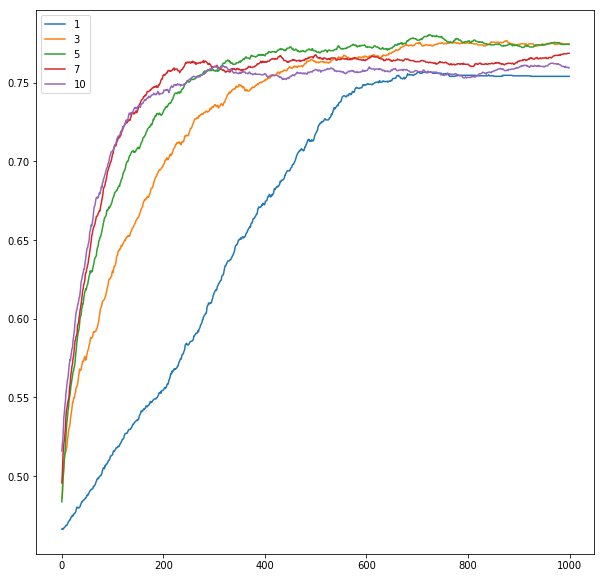

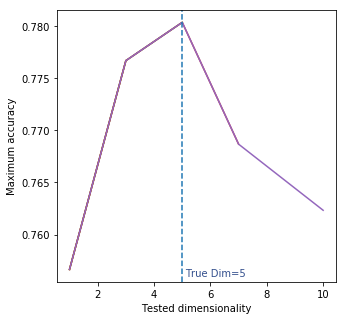

In [129]:
for h,w in zip(histoires, nn_dimensions):
    x = range(len(h))
    loss = [tup[0] for tup in h]
    acc = [tup[2] for tup in h]
#     plt.plot(x,loss, label=w)
    plt.plot(x,acc, label=w)
plt.gcf().set_size_inches(10, 10)
plt.legend()
plt.show()

x=[]
tops=[]
for h,w in zip(histoires, nn_dimensions):
    x.append(w)
#     loss = [tup[0] for tup in h]
    tops.append(max( [tup[2] for tup in h]))
#     plt.plot(x,loss, label=w)
    plt.plot(x,tops)
plt.gcf().set_size_inches(5, 5)
plt.xlabel("Tested dimensionality")
plt.ylabel("Maximum accuracy")
plt.axvline(x=5, linestyle="--")
plt.text(x=5.1, y=plt.ylim()[0]+.0005, s='True Dim=5', color='#334f8d')
plt.show()


elements in h: 16
(0.91572104566097257, 0.31946941799759865, 0.50490500000000005)
(0.74795270622730259, 0.26656289949178696, 0.55831500000000001)
(0.70781433809757233, 0.25214002320945261, 0.57898000000000005)
(0.69419102789163589, 0.24716706697940827, 0.58570999999999995)
(0.68923943117856978, 0.24506311622858049, 0.59079749999999998)
(0.68936642273187643, 0.24473972714185716, 0.59324750000000004)
(0.69110158857107162, 0.24499028292238711, 0.59500750000000002)
(0.69294615130662918, 0.24527216579735278, 0.59675999999999996)
(0.69496327038288119, 0.245644258351326, 0.59762999999999999)
(0.69681172864198682, 0.24593349490225316, 0.59855499999999995)
(0.69888650999307633, 0.24636338090300561, 0.59948749999999995)
(0.70049507125139232, 0.24661929389417173, 0.60045999999999999)
(0.70214721165895466, 0.24688927276551723, 0.60148250000000003)
(0.70388557514905925, 0.24720468823790551, 0.60189749999999997)
(0.7056189635252953, 0.24751434554576873, 0.60218000000000005)
(0.70692129829645156, 0.2

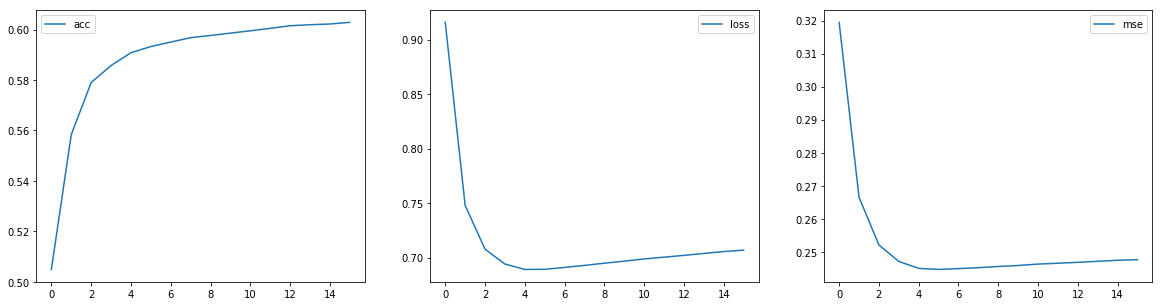

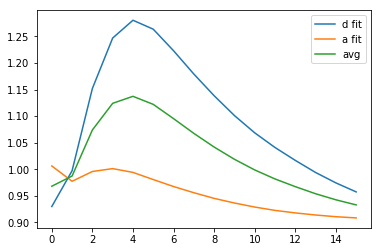

In [41]:
clear_output()
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="d fit")
plt.plot(th_fit_rmses, label="a fit")
plt.plot(av_fit_rmses, label="avg")
plt.legend()
plt.show()


In [42]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

real [[ 10.94075004  22.75399221   3.02906814 ...,   6.72877459  20.43593973
   22.75860242]
 [ 18.44587     20.37251586  10.53584258 ...,   4.1173489   13.44871124
    2.26915354]
 [  1.26812714   9.4565488    8.01395252 ...,   7.81788147  11.35180179
    2.91717035]
 ..., 
 [ 17.22519531  21.89358942   7.5251736  ...,  16.71762217  10.37545902
    1.25429202]
 [  1.69554747  12.04235123   2.34800522 ...,   8.62958737   8.70572464
   16.25472114]
 [ 22.20753878  12.25477271   2.63920166 ...,   1.26050169   9.7134637
    1.40080527]]
out [[ 14.57091904   5.11206484  21.26072311 ...,  19.24503326   5.26015949
   21.99741554]
 [  7.53768253  20.50618744  17.39183807 ...,  19.01119804   7.80742502
    7.81177998]
 [ 18.49344635   1.96794021  21.32787895 ...,   7.58776999  11.02748299
   10.37238121]
 ..., 
 [ 19.39649391  21.18089485  18.89954758 ...,  10.91354275  20.27309227
    2.91121435]
 [ 10.47409534  10.81981468   1.44396937 ...,  11.83677197   7.60482073
   20.65550041]
 [ 20.725

In [43]:
x = []

for _ in range(1):
    xa, _, _, _ = generate_attempts(qs,ss)
    x.extend(xa)

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
    summa += log((p if passed else (1-p)), base)

    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1

acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

----0

>>Passed 200763/400000
model acc: 0.652635
131363 69546
69400 129691
perplexity is 1.6787769647276936
140618 : 131363 129691 69546 69400


In [44]:
sws = s_table.get_weights()[0]

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(sws[psi_id], pred_wgtz[q_id])
    summa += log((p if passed else (1-p)), base)

    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1

acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

model acc: 0.5428025
108983 91099
91780 108138
perplexity is 1.993226564630819
183724 : 108983 108138 91099 91780


(200, 100) (200, 100)


/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


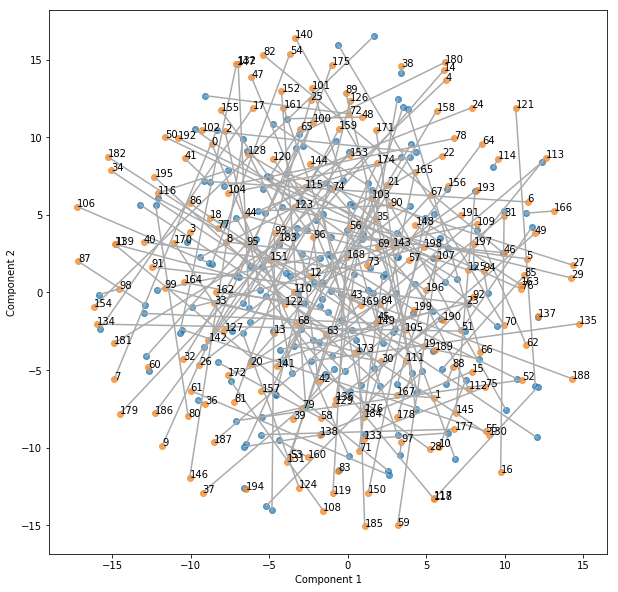

In [45]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
fig.show()